Get device info

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Fri May  5 12:40:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L
!lscpu | grep 'Model name'
!lscpu | grep '^CPU(s)'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep 'Core(s) per socket'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'CPU MHz'
!awk 'NR==3 {printf "Available memory:\t\t %.fG\n",$2/1024^2}' /proc/meminfo
!df -h / | awk 'NR==2 {print "Available disk:\t\t\t "$4}'

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-06e65ea9-f021-411a-5f92-462b8a466d0a)
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
CPU(s):                          12
Thread(s) per core:              2
Core(s) per socket:              6
Socket(s):                       1
CPU MHz:                         2200.204
Available memory:		 82G
Available disk:			 143G


Connect to Google drive and import dataset

In [ ]:
%%capture
from google.colab import drive
drive.mount('drive')

In [ ]:
%%capture
import os

if not os.path.exists('data'):
  !mkdir 'data'
!tar -xzvf 'drive/MyDrive/classification/food-101.tar.gz' -C 'data'

Import modules

In [ ]:
%%capture
%pip install timm

In [ ]:
import gc
from pathlib import Path

#import timm
from fastai.data.all import *
from fastai.vision.all import *

Find timm model

In [ ]:
MODEL = models.efficientnet_v2_s


In [ ]:
TIMM_MODELS = timm.list_models('*swin*')
TIMM_MODELS

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_s3_base_224',
 'swin_s3_small_224',
 'swin_s3_tiny_224',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224',
 'swinv2_base_window8_256',
 'swinv2_base_window12_192_22k',
 'swinv2_base_window12to16_192to256_22kft1k',
 'swinv2_base_window12to24_192to384_22kft1k',
 'swinv2_base_window16_256',
 'swinv2_cr_base_224',
 'swinv2_cr_base_384',
 'swinv2_cr_base_ns_224',
 'swinv2_cr_giant_224',
 'swinv2_cr_giant_384',
 'swinv2_cr_huge_224',
 'swinv2_cr_huge_384',
 'swinv2_cr_large_224',
 'swinv2_cr_large_384',
 'swinv2_cr_small_224',
 'swinv2_cr_small_384',
 'swinv2_cr_small_ns_224',
 'swinv2_cr_tiny_224',
 'swinv2_cr_tiny_384',
 'swinv2_cr_tiny_ns_224',
 'swinv2_large_window12_192_22

Declare constants

In [ ]:
IMAGE_DIR = 'data/food-101/images'
META_DIR = 'data/food-101/meta'
TRAIN_SET = open(Path(META_DIR + '/train.txt')).read().split('\n')[:-1]
TEST_SET = open(Path(META_DIR + '/test.txt')).read().split('\n')[:-1]
CLASSES = open(Path(META_DIR + '/classes.txt')).read().split('\n')[:-1]

In [ ]:
# MODEL = FASTAI
#MODEL = TIMM_MODELS[0]
MODEL_NAME = MODEL if isinstance(MODEL, str) else str(MODEL).split(' ')[1]
MIXED_PRECISION = False

LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 64

CBS = SaveModelCallback()
METRICS = [error_rate, accuracy, top_k_accuracy]
SUGGEST_FUNC = (minimum, steep, valley, slide)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Image pre-processing

In [ ]:
itfms = (Resize(224))
btfms = aug_transforms(size=224)

Setup dataloader

In [ ]:
def dataloader(dataset, **kwargs):
  fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in dataset]
  labels = [i.split('/')[0] for i in dataset]
  params = {'seed': 42, 'bs': BATCH_SIZE}
  if kwargs:
    params.update(kwargs)
  return ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, **params)

In [ ]:
dls = dataloader(TRAIN_SET, item_tfms=itfms, batch_tfms=btfms, device=DEVICE)
dls_test = dataloader(TEST_SET, valid_pct=0, item_tfms=itfms, batch_tfms=btfms, device=DEVICE)

In [ ]:
print(f'train items: {dls.train.n}, train classes: {len(dls.train.vocab)}')
print(f'valid items: {dls.valid.n}, valid classes: {len(dls.valid.vocab)}')
print(f'test items: {dls_test.train.n}, test classes: {len(dls_test.train.vocab)}')

train items: 60600, train classes: 101
valid items: 15150, valid classes: 101
test items: 25250, test classes: 101


Setup model

In [ ]:
%%capture
learner = vision_learner(dls, MODEL, n_out=101, metrics=METRICS, lr=LR, cbs=CBS)
if MIXED_PRECISION:
  learner.to_fp16()
if DEVICE == 'cuda:0':
  learner.cuda
else:
  learner.cpu

In [ ]:
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, m

In [ ]:
learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallbac

In [ ]:
learner.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 128 x 56 x 56  
Conv2d                                    6272       False     
LayerNorm                                 256        True      
Dropout                                                        
LayerNorm                                 256        True      
____________________________________________________________________________
                     64 x 49 x 384       
Linear                                    49536      False     
Dropout                                                        
Linear                                    16512      False     
Dropout                                                        
Softmax                                                        
Identity                                                       
LayerNorm                                 256        True      
__________________________

Train model

minimum: 0.010000000149011612
steep: 0.0063095735386013985
valley: 0.0005754399462603033
slide: 0.002511886414140463



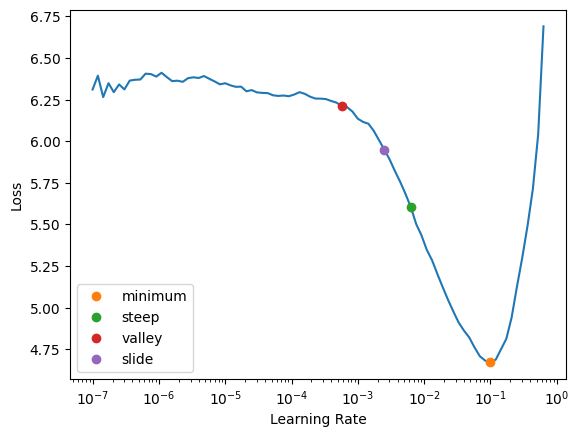

In [ ]:
lrs = learner.lr_find(suggest_funcs=SUGGEST_FUNC)
print(f'minimum: {lrs.minimum}')
print(f'steep: {lrs.steep}')
print(f'valley: {lrs.valley}')
print(f'slide: {lrs.slide}\n')

In [ ]:
learner.fine_tune(EPOCHS, lrs.valley)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.185449,0.714394,0.193729,0.806271,0.953531,07:33


Better model found at epoch 0 with valid_loss value: 0.714393675327301.


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.951761,0.609924,0.164752,0.835248,0.963168,09:52
1,0.848331,0.539417,0.147657,0.852343,0.966337,09:52
2,0.681101,0.503993,0.137030,0.862970,0.969901,09:52
3,0.624669,0.473498,0.127591,0.872409,0.973399,09:52
4,0.620359,0.450272,0.120396,0.879604,0.973927,09:51
5,0.519798,0.443800,0.119010,0.880990,0.974587,09:52
6,0.498853,0.436171,0.118350,0.881650,0.974984,09:52
7,0.461342,0.429735,0.115182,0.884818,0.975116,09:52
8,0.456155,0.429031,0.114719,0.885281,0.975512,09:52
9,0.444791,0.427032,0.114257,0.885743,0.975446,09:52


Better model found at epoch 0 with valid_loss value: 0.6099236011505127.
Better model found at epoch 1 with valid_loss value: 0.5394169688224792.
Better model found at epoch 2 with valid_loss value: 0.5039930939674377.
Better model found at epoch 3 with valid_loss value: 0.4734984338283539.
Better model found at epoch 4 with valid_loss value: 0.4502722918987274.
Better model found at epoch 5 with valid_loss value: 0.4438001811504364.
Better model found at epoch 6 with valid_loss value: 0.4361706078052521.
Better model found at epoch 7 with valid_loss value: 0.4297349750995636.
Better model found at epoch 8 with valid_loss value: 0.4290308952331543.
Better model found at epoch 9 with valid_loss value: 0.427031546831131.


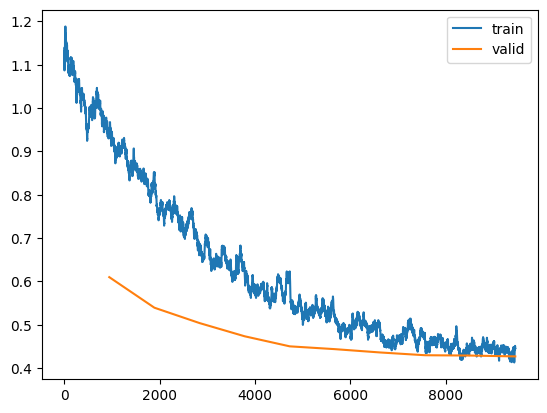

In [ ]:
learner.recorder.plot_loss()

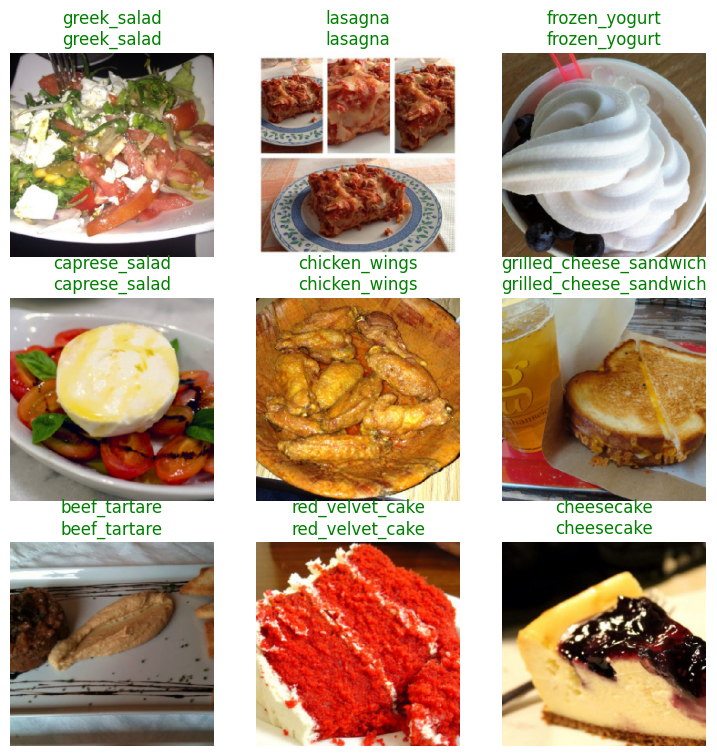

In [ ]:
learner.show_results()

Model inference

In [ ]:
train_infer = '\t\t'.join([f'{i:.4f}' for i in learner.validate(0)])
valid_infer = '\t\t'.join([f'{i:.4f}' for i in learner.validate()])

Better model found at epoch 0 with valid_loss value: 0.0792316347360611.


Better model found at epoch 0 with valid_loss value: 0.11425742506980896.


In [ ]:
print('\t\t'.join(['', 'Loss', 'Error', 'Top 1', 'Top 5']))
print(f'Train\t\t{train_infer}')
print(f'Valid\t\t{valid_infer}')

		Loss		Error		Top 1		Top 5
Train		0.2743		0.0792		0.9208		0.9892
Valid		0.4270		0.1143		0.8857		0.9754


In [ ]:
learner.export()

In [ ]:
del learner
gc.collect()
torch.cuda.empty_cache()

Extract features

In [ ]:
!cp -r 'drive/MyDrive/export.pkl' 'data/food-101/images/'

In [ ]:
learner = load_learner(f'{IMAGE_DIR}/export.pkl', DEVICE == 'cpu')

In [ ]:
%%capture
learner = vision_learner(dls, MODEL, n_out=101, metrics=METRICS, lr=LR, cbs=CBS)

In [ ]:
learner.load('/content/drive/MyDrive/swin_base_patch4_window7_224')

In [ ]:
if MIXED_PRECISION:
  learner.to_fp16()
if DEVICE == 'cuda:0':
  learner.cuda
else:
  learner.cpu

In [ ]:
new_head = cut_model(learner.model[-1], 2)
learner.model[-1] = new_head

In [ ]:
x, y = dls.one_batch()
print(learner.model(x).shape)
learner.model(x)

torch.Size([64, 1024])


TensorImage([[-0.9063, -0.0806, -0.3791,  ..., -0.8924,  0.7935, -0.0504],
             [-0.3405,  0.4822, -0.4172,  ..., -0.3622, -0.0838, -0.2008],
             [-0.9303, -0.0156, -0.3259,  ..., -0.9772,  0.0340,  0.3941],
             ...,
             [-0.5805,  1.4680, -0.3255,  ..., -0.1338, -0.0144,  1.5600],
             [-0.1897, -0.2730, -0.0018,  ..., -0.3240, -0.0075,  0.5216],
             [-0.0600, -0.0624,  0.3116,  ..., -1.2311, -0.4710,  0.4736]],
            device='cuda:0', grad_fn=<AliasBackward0>)

In [ ]:
def feature_extractor(dl, dl_type):
  folder = f'features/{dl_type}'
  print(dl_type)
  if not os.path.exists(folder):
    os.mkdir(folder)
  count = 1
  for x, y in iter(dl):
    if count % 100 == 0 or count == int(dl.n / BATCH_SIZE):
      print(count)
    batch = x.float().to(DEVICE)
    features = learner.model(batch)
    del batch
    gc.collect()
    torch.cuda.empty_cache()
    torch.save((features, y), f'features/{dl_type}/batch_{dl_type}_{count}.pt')
    del features
    del x
    del y
    gc.collect()
    torch.cuda.empty_cache()
    count += 1

In [ ]:
if not os.path.exists('features'):
  os.mkdir('features')
feature_extractor(dls.train, 'train')
feature_extractor(dls.valid, 'valid')
feature_extractor(dls_test.train, 'test')

SVM classifier

In [ ]:
#for copying features to the drive for archive
if not os.path.exists('features'):
  os.mkdir('features')
!tar -czvf 'drive/MyDrive/features_'$MODEL_NAME'.tar.gz' 'features'

features/
features/test/
features/test/batch_test_105.pt
features/test/batch_test_8.pt
features/test/batch_test_168.pt
features/test/batch_test_95.pt
features/test/batch_test_323.pt
features/test/batch_test_94.pt
features/test/batch_test_343.pt
features/test/batch_test_3.pt
features/test/batch_test_102.pt
features/test/batch_test_142.pt
features/test/batch_test_206.pt
features/test/batch_test_333.pt
features/test/batch_test_328.pt
features/test/batch_test_158.pt
features/test/batch_test_111.pt
features/test/batch_test_337.pt
features/test/batch_test_360.pt
features/test/batch_test_126.pt
features/test/batch_test_336.pt
features/test/batch_test_21.pt
features/test/batch_test_189.pt
features/test/batch_test_72.pt
features/test/batch_test_130.pt
features/test/batch_test_281.pt
features/test/batch_test_358.pt
features/test/batch_test_54.pt
features/test/batch_test_152.pt
features/test/batch_test_290.pt
features/test/batch_test_35.pt
features/test/batch_test_50.pt
features/test/batch_test_3

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
FEATURES_DIR = 'data/features'

In [ ]:
!tar -xzvf 'drive/MyDrive/features_'$MODEL_NAME'.tar.gz' -C 'data'

features/
features/test/
features/test/batch_test_105.pt
features/test/batch_test_8.pt
features/test/batch_test_168.pt
features/test/batch_test_95.pt
features/test/batch_test_323.pt
features/test/batch_test_94.pt
features/test/batch_test_343.pt
features/test/batch_test_3.pt
features/test/batch_test_102.pt
features/test/batch_test_142.pt
features/test/batch_test_206.pt
features/test/batch_test_333.pt
features/test/batch_test_328.pt
features/test/batch_test_158.pt
features/test/batch_test_111.pt
features/test/batch_test_337.pt
features/test/batch_test_360.pt
features/test/batch_test_126.pt
features/test/batch_test_336.pt
features/test/batch_test_21.pt
features/test/batch_test_189.pt
features/test/batch_test_72.pt
features/test/batch_test_130.pt
features/test/batch_test_281.pt
features/test/batch_test_358.pt
features/test/batch_test_54.pt
features/test/batch_test_152.pt
features/test/batch_test_290.pt
features/test/batch_test_35.pt
features/test/batch_test_50.pt
features/test/batch_test_3

In [ ]:
def load(folder, x=None, y=None):
  files = os.listdir(folder)
  if x is None and y is None:
    t1 = torch.load(f'{folder}/{files[0]}', DEVICE)
    t2 = torch.load(f'{folder}/{files[1]}', DEVICE)
    x = torch.cat((t1[0], t2[0]), 0)
    y = torch.cat((t1[1], t2[1]), 0)
    files = files[2:]
  for f in files:
    t = torch.load(f'{folder}/{files[0]}', DEVICE)
    x = torch.cat((x, t[0]), 0)
    y = torch.cat((y, t[1]), 0)
  return x, y

In [ ]:
x_train, y_train = load(f'{FEATURES_DIR}/train')
x_test, y_test = load(f'{FEATURES_DIR}/test')
x_val, y_val = load(f'{FEATURES_DIR}/valid')

In [ ]:
x_train = x_train.cpu().detach().numpy()
y_train = y_train.cpu().detach().numpy()
x_test = x_test.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()
x_val = x_val.cpu().detach().numpy()
y_val = y_val.cpu().detach().numpy()

In [ ]:
x_train  = np.asarray(x_train).squeeze()
y_train  = np.asarray(y_train).squeeze()
x_val  = np.asarray(x_val).squeeze()
y_val  = np.asarray(y_val).squeeze()

In [ ]:
clf = svm.SVC(decision_function_shape='ovr', kernel="linear", C=1e6, probability=True, verbose=True)
clf.fit(x_train, dls.train.)

[LibSVM]

SVC(C=1000000.0, kernel='linear', probability=True, verbose=True)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_val_pred = clf.predict(x_val)
print("Accuracy: "+str(accuracy_score(y_val, y_val_pred)))
#print('\n')
#print(classification_report(y_val, y_pred))

Accuracy: 0.4537183544303797


In [ ]:
y_test_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.4066069162436548


DecisionTreeClassifier Model

In [ ]:
from sklearn import tree               #classifier
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(x_train, y_train)

In [ ]:
y_val_pred = clf_tree.predict(x_val)
print("Accuracy: "+str(accuracy_score(y_val, y_val_pred)))

Accuracy: 0.04720464135021097


In [ ]:
y_test_pred = clf_tree.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.03152760152284264


RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators = 50, random_state = 42)
clf_RF = clf_RF.fit(x_train, y_train)

In [ ]:
y_val_pred = clf_RF.predict(x_val)
print("Accuracy: "+str(accuracy_score(y_val, y_val_pred)))

Accuracy: 0.2344409282700422


In [ ]:
y_test_pred = clf_RF.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_test_pred)))

Accuracy: 0.18813451776649745
